In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

In [ ]:
DIR = '/content/drive/MyDrive/Kaggle/'
import pandas as pd
import os
import catboost
import numpy as np

Load the data:

In [ ]:
try:
    train_df = pd.read_csv(os.path.join(DIR, 'train.csv'))
    test_df = pd.read_csv(os.path.join(DIR, 'test_unlabeled.csv'))
    features_df = pd.read_parquet(os.path.join(DIR, 'engineered_features_100s_v1.parquet'))
    # --- Assume X_train, y_train, X_test are loaded ---

    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    print(f"Features shape: {features_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure the path '{DIR}' is correct and contains the necessary files.")
    # Exit or handle error appropriately if files are missing
    exit()

Data loaded successfully.
Train shape: (639557, 6)
Test shape: (478832, 4)
Features shape: (1061444, 70)


Prepare training
1. Merge train labels with the engineered features
2. We use a left merge from train_df to keep all train mints.
3. Mints in train_df that are NOT in features_df will have NaN for features.
4. (This could happen if a train mint didn't have creation metadata or 0 activity in first 100 slots)

In [ ]:
train_labeled_features = pd.merge(
    train_df[['mint', 'has_graduated']], # Keep only mint and target from train
    features_df,
    on='mint',
    how='left'
)

print(f"\nTraining data shape after merging features: {train_labeled_features.shape}")
print("Training data head:")
print(train_labeled_features.head())

# Identify features (all columns except 'mint' and 'has_graduated')
feature_columns = [col for col in train_labeled_features.columns if col not in ['mint', 'has_graduated', 'first_time_100s', 'last_time_100s']]
# Note: Dropped datetime columns as CatBoost expects numerical/categorical

X_train_full = train_labeled_features[feature_columns]
y_train_full = train_labeled_features['has_graduated']
X_test = test_df.merge(features_df, on='mint', how='left')


# Handle potential NaNs in training features. CatBoost can handle NaNs natively,
# which is often better than imputation. We don't need to explicitly fill NaNs here
# if using CatBoost, just ensure the data is ready.

print(f"\nTraining features shape (X_train): {X_train.shape}")
print(f"Training target shape (y_train): {y_train.shape}")
print("X_train info (showing NaNs):")
X_train.info(verbose=True, show_counts=True)


Training data shape after merging features: (639557, 71)
Training data head:
                                           mint  has_graduated  tx_count_100s  \
0  BmTDA5HqcemLkEgpyK25sDhbvk652CTXjdWEa8fLpump          False            3.0   
1  4FJwryCAMMePNeWw9LTBXXfXABdkKcAxkTT6h9pdpump          False            1.0   
2  DeXchZLMzFm9nfvkfTKiXvBWWEpGMF6VDzvbMB6mpump          False            3.0   
3  6Mx4fnEPWpRLKtxY8VzVXo3CWwu2dvGp9BSJMWfVpump          False            1.0   
4  4rbGH5peYV3FvCfncfsfwtBNwpjiG36nZtvxoPZ9pump          False           13.0   

   buy_tx_count_100s  sell_tx_count_100s  total_sol_vol_100s  \
0                2.0                 1.0        5.656629e+09   
1                1.0                 0.0        2.000000e+09   
2                2.0                 1.0        2.574964e+09   
3                1.0                 0.0        4.000000e+09   
4                8.0                 5.0        7.874963e+09   

   buy_sol_vol_100s  sell_sol_vol_100s  total_toke

In [ ]:
import pandas as pd
import numpy as np
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report, confusion_matrix, log_loss

# --- Assume X_train_full, y_train_full contain ALL features and targets ---
# --- 1. Create Train/Validation Split ---
print("Creating train/validation split...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,         # Or your preferred split size
    random_state=42,
    stratify=y_train_full  # Essential for imbalanced data!
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"Validation positive class proportion: {np.mean(y_val):.4f}")

# --- 2. Train Baseline Model with Validation ---
print("\nTraining Baseline CatBoost model with validation...")
baseline_model = catboost.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='Logloss',    # Keep Logloss for CatBoost optimization for now
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
    task_type='GPU',
    # NO scale_pos_weight yet
)

baseline_model.fit(X_train, y_train,
                   eval_set=(X_val, y_val),
                   # No categorical features specified
                  )
print("Baseline training complete.")

# --- 3. Evaluate Baseline Robustly ---
print("\nEvaluating Baseline Model...")
val_preds_proba = baseline_model.predict_proba(X_val)[:, 1]
val_preds_binary = baseline_model.predict(X_val)

print(f"Validation LogLoss: {log_loss(y_val, val_preds_proba):.4f}")
print(f"Validation ROC AUC: {roc_auc_score(y_val, val_preds_proba):.4f}")
# Note: average_precision_score is equivalent to PRAUC
print(f"Validation PR AUC: {average_precision_score(y_val, val_preds_proba):.4f}")
print(f"Validation F1 Score: {f1_score(y_val, val_preds_binary):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, val_preds_binary))
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, val_preds_binary))

Creating train/validation split...
X_train shape: (511645, 67), y_train shape: (511645,)
X_val shape: (127912, 67), y_val shape: (127912,)
Validation positive class proportion: 0.0116

Training Baseline CatBoost model with validation...
0:	learn: 0.5769393	test: 0.5769808	best: 0.5769808 (0)	total: 18.1ms	remaining: 18.1s
100:	learn: 0.0390938	test: 0.0401614	best: 0.0401614 (100)	total: 1.17s	remaining: 10.4s
200:	learn: 0.0383418	test: 0.0398777	best: 0.0398777 (200)	total: 2.22s	remaining: 8.81s
300:	learn: 0.0378182	test: 0.0397413	best: 0.0397413 (300)	total: 3.25s	remaining: 7.55s
400:	learn: 0.0373657	test: 0.0396985	best: 0.0396985 (400)	total: 4.28s	remaining: 6.39s
500:	learn: 0.0369441	test: 0.0396601	best: 0.0396550 (495)	total: 5.31s	remaining: 5.29s
600:	learn: 0.0365249	test: 0.0396093	best: 0.0396093 (600)	total: 6.35s	remaining: 4.21s
700:	learn: 0.0361673	test: 0.0395912	best: 0.0395863 (687)	total: 9.92s	remaining: 4.23s
800:	learn: 0.0358000	test: 0.0395722	best: 0.

In [ ]:
import pandas as pd
import numpy as np
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report, confusion_matrix, log_loss

# --- Assume X_train_full, y_train_full contain ALL features and targets ---
# --- 1. Create Train/Validation Split ---
print("Creating train/validation split...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,         # Or your preferred split size
    random_state=42,
    stratify=y_train_full  # Essential for imbalanced data!
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"Validation positive class proportion: {np.mean(y_val):.4f}")

# --- 2. Train Baseline Model with Validation ---
tuned_weight = 25 # Example value found through experimentation

weighted_model = catboost.CatBoostClassifier(
    iterations=2000, # Might need more/fewer iterations
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss', # Loss function often kept as Logloss
    eval_metric='F1',       # **** CHANGED EVAL METRIC ****
    scale_pos_weight=tuned_weight, # **** ADDED TUNED WEIGHT ****
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100, # May need larger patience with F1/AUC
    task_type='GPU',
)

weighted_model.fit(X_train, y_train,
                   eval_set=(X_val, y_val))

print("Weighted model training complete.")

# --- 3. Evaluate Baseline Robustly ---
print("\nEvaluating Weighted Model...")
val_preds_proba = baseline_model.predict_proba(X_val)[:, 1]
val_preds_binary = baseline_model.predict(X_val)

print(f"Validation LogLoss: {log_loss(y_val, val_preds_proba):.4f}")
print(f"Validation ROC AUC: {roc_auc_score(y_val, val_preds_proba):.4f}")
# Note: average_precision_score is equivalent to PRAUC
print(f"Validation PR AUC: {average_precision_score(y_val, val_preds_proba):.4f}")
print(f"Validation F1 Score: {f1_score(y_val, val_preds_binary):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, val_preds_binary))
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, val_preds_binary))

Creating train/validation split...
X_train shape: (511645, 67), y_train shape: (511645,)
X_val shape: (127912, 67), y_val shape: (127912,)
Validation positive class proportion: 0.0116
0:	learn: 0.6521470	test: 0.6387969	best: 0.6387969 (0)	total: 54.4ms	remaining: 1m 48s
100:	learn: 0.6770121	test: 0.6570137	best: 0.6582139 (93)	total: 2.08s	remaining: 39.2s
bestTest = 0.6582138735
bestIteration = 93
Shrink model to first 94 iterations.
Weighted model training complete.

Evaluating Weighted Model...
Validation LogLoss: 0.0396
Validation ROC AUC: 0.8703
Validation PR AUC: 0.4536
Validation F1 Score: 0.4581

Validation Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    126431
        True       0.91      0.31      0.46      1481

    accuracy                           0.99    127912
   macro avg       0.95      0.65      0.73    127912
weighted avg       0.99      0.99      0.99    127912


Validation Confusion Mat

In [ ]:
import pandas as pd
import numpy as np
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report, confusion_matrix, log_loss
import time

# --- 1. Create Train/Validation Split ---
print("Creating train/validation split...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, # Use the full dataset here for splitting
    test_size=0.2,
    random_state=42,
    stratify=y_train # Stratify on the full dataset labels
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"Validation positive class proportion: {np.mean(y_val):.4f}")

# --- Define parameters (fixed and to be tuned) ---
tuned_weight = 40 # Example value
base_params = {
    'iterations': 2000,
    'learning_rate': 0.01,
    'depth': 7,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'scale_pos_weight': tuned_weight,
    'random_seed': 42,
    'verbose': 0, # Turn off verbose during tuning loop for cleaner output
    'early_stopping_rounds': 100,
    'task_type': 'GPU', # or 'CPU' if you don't have GPU support
}

# --- 2. Tune l2_leaf_reg ---
print("\nTuning l2_leaf_reg...")
l2_leaf_reg_values = [0.1, 1.0, 3.0, 5.0, 10.0, 20.0, 30.0] # Example values to try
best_l2_leaf_reg = None
best_val_f1 = -1 # Initialize with a value lower than any possible F1 score
best_iteration = None # Store the best iteration count

results = {} # Optional: store results for all values

start_time = time.time()

for reg_val in l2_leaf_reg_values:
    print(f"  Trying l2_leaf_reg = {reg_val}...")
    current_params = base_params.copy()
    current_params['l2_leaf_reg'] = reg_val # *** SET THE PARAMETER HERE ***

    model = catboost.CatBoostClassifier(**current_params)

    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True) # IMPORTANT: ensures model uses weights from best iteration

    # Get the best F1 score achieved on the validation set during training
    val_f1 = model.get_best_score()['validation']['F1']
    print(f"    Validation F1: {val_f1:.4f} at iteration {model.get_best_iteration()}")

    results[reg_val] = {'f1': val_f1, 'best_iter': model.get_best_iteration()} # Store results

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_l2_leaf_reg = reg_val
        best_iteration = model.get_best_iteration() # Store optimal iterations for this reg value

end_time = time.time()
print(f"\nTuning finished in {end_time - start_time:.2f} seconds.")
print(f"Best l2_leaf_reg found: {best_l2_leaf_reg}")
print(f"Best Validation F1 Score: {best_val_f1:.4f} (achieved at iteration {best_iteration})")

# --- 3. Train Final Model with Best Parameter ---
print(f"\nTraining final model with l2_leaf_reg = {best_l2_leaf_reg}...")

final_params = base_params.copy()
final_params['l2_leaf_reg'] = best_l2_leaf_reg
# Optional: Adjust iterations based on tuning, but early stopping handles this.
# If not using early stopping in final training, set iterations=best_iteration
final_params['verbose'] = 100 # Turn verbose back on for final training

final_model = catboost.CatBoostClassifier(**final_params)

# Train on the full training data (or keep train/val split if you prefer monitoring)
# Option 1: Train on original X_train, validate on X_val (like before)
final_model.fit(X_train, y_train,
                eval_set=(X_val, y_val),
                use_best_model=True) # Keeps the best model based on validation F1

print("Weighted model training complete.")

# --- 3. Evaluate Weighted Robustly ---
print("\nEvaluating Weighted Model...")
val_preds_proba = final_model.predict_proba(X_val)[:, 1]
val_preds_binary = final_model.predict(X_val)

print(f"Validation LogLoss: {log_loss(y_val, val_preds_proba):.4f}")
print(f"Validation ROC AUC: {roc_auc_score(y_val, val_preds_proba):.4f}")
# Note: average_precision_score is equivalent to PRAUC
print(f"Validation PR AUC: {average_precision_score(y_val, val_preds_proba):.4f}")
print(f"Validation F1 Score: {f1_score(y_val, val_preds_binary):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, val_preds_binary))
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, val_preds_binary))

Creating train/validation split...
X_train shape: (511645, 67), y_train shape: (511645,)
X_val shape: (127912, 67), y_val shape: (127912,)
Validation positive class proportion: 0.0116
0:	learn: 0.6521470	test: 0.6387969	best: 0.6387969 (0)	total: 25ms	remaining: 49.9s
100:	learn: 0.6711423	test: 0.6482749	best: 0.6488459 (98)	total: 3.27s	remaining: 1m 1s
200:	learn: 0.6801361	test: 0.6549778	best: 0.6550108 (199)	total: 8.38s	remaining: 1m 14s
300:	learn: 0.6867101	test: 0.6545381	best: 0.6561504 (229)	total: 11.6s	remaining: 1m 5s
bestTest = 0.6561503608
bestIteration = 229
Shrink model to first 230 iterations.
Weighted model training complete.

Evaluating Weighted Model...
Validation LogLoss: 0.0396
Validation ROC AUC: 0.8703
Validation PR AUC: 0.4536
Validation F1 Score: 0.4581

Validation Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00    126431
        True       0.91      0.31      0.46      1481

    accu

In [ ]:
import pandas as pd
import numpy as np
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report, confusion_matrix, log_loss

import pandas as pd
import numpy as np
import catboost
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    classification_report, confusion_matrix, log_loss
)
import time

# --- 0. Load your FULL dataset (assuming it's ready) ---
# Example:
# data = pd.read_csv('your_data.csv')
# X_full = data.drop('has_graduated_numeric', axis=1) # Replace with your features
# y_full = data['has_graduated_numeric']             # Replace with your target
# print("Full dataset loaded.")
# print(f"X_full shape: {X_full.shape}, y_full shape: {y_full.shape}")

# --- Ensure you have X_train_full, y_train_full defined before this script ---
# --- For demonstration, assuming they exist from previous steps ---
# Example placeholder (replace with your actual full training data):
# X_train_full = pd.DataFrame(np.random.rand(10000, 67)) # Placeholder
# y_train_full = pd.Series(np.random.randint(0, 2, 10000)) # Placeholder
# print(f"Using full training data: X={X_train_full.shape}, y={y_train_full.shape}")


# --- 1. Create Train/Validation Split (Crucial!) ---
# Split the *full* training data ONCE before tuning
print("Creating train/validation split...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, # Use your full training data here
    test_size=0.25,          # Using 25% for validation is common during tuning
    random_state=42,
    stratify=y_train_full     # Stratify based on the full labels
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"Validation positive class proportion: {np.mean(y_val):.4f}")


# --- 2. Define the Optuna Objective Function ---
def objective(trial):
    """Objective function for Optuna"""

    # Define hyperparameters to tune
    params = {
        'objective': 'Logloss', # Standard loss function
        'eval_metric': 'F1',    # Metric for early stopping & internal checks
        'task_type': 'GPU',     # or 'CPU'
        'random_seed': 42,
        'verbose': 0,           # Suppress verbose output during tuning runs
        'early_stopping_rounds': 50, # Stop early if eval_metric doesn't improve

        # --- Hyperparameters suggested by Optuna ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08, log=True),
        'depth': trial.suggest_int('depth', 5, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5, 15.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 15.0, 35.0), # Fine-tuning the weight
        # 'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0), # <-- REMOVE OR COMMENT OUT THIS LINE
        # 'iterations': trial.suggest_int('iterations', 800, 3000) # Usually better to rely on early stopping
    }

    # Fixed high number of iterations, rely on early stopping
    iterations = 2500

    # Initialize CatBoost model
    model = catboost.CatBoostClassifier(iterations=iterations, **params)

    # Train the model
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
             )

    # Make predictions on validation set (probabilities for PR AUC)
    val_preds_proba = model.predict_proba(X_val)[:, 1]

    # Calculate PR AUC (Average Precision Score) - This is what we MAXIMIZE
    pr_auc = average_precision_score(y_val, val_preds_proba)

    return pr_auc # Return the score Optuna should optimize

# --- 3. Run Optuna Study ---
print("\nStarting Optuna hyperparameter search...")
# Consider using TPESampler for potentially better results
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

# Start the optimization
start_time = time.time()
study.optimize(objective, n_trials=50) # Run for 50 trials (adjust as needed based on time/resources)
end_time = time.time()

print(f"\nOptuna study finished in {end_time - start_time:.2f} seconds.")

# --- 4. Get Best Results ---
best_trial = study.best_trial
best_params_optuna = best_trial.params
best_pr_auc = best_trial.value

print(f"Best Validation PR AUC: {best_pr_auc:.4f}")
print("Best hyperparameters found:")
for key, value in best_params_optuna.items():
    print(f"  {key}: {value}")

# --- 5. Train Final Model with Best Parameters ---
print("\nTraining final model with best hyperparameters found by Optuna...")

# Combine base parameters with the best ones found by Optuna
final_params = {
    'objective': 'Logloss',
    'eval_metric': 'F1',
    'task_type': 'GPU',
    'random_seed': 42,
    'verbose': 100,             # Turn verbose back on
    'early_stopping_rounds': 50,
    **best_params_optuna        # Add the tuned parameters
}

# Use a fixed high number of iterations, rely on early stopping
iterations = 3000 # Can increase slightly for final model

final_model = catboost.CatBoostClassifier(iterations=iterations, **final_params)

# Train on the same training data, validate on the same validation data
final_model.fit(X_train, y_train,
                eval_set=(X_val, y_val),
                use_best_model=True)

print("Weighted model training complete.")

# --- 3. Evaluate Baseline Robustly ---
print("\nEvaluating Weighted Model...")
val_preds_proba = final_model.predict_proba(X_val)[:, 1]
val_preds_binary = final_model.predict(X_val)

print(f"Validation LogLoss: {log_loss(y_val, val_preds_proba):.4f}")
print(f"Validation ROC AUC: {roc_auc_score(y_val, val_preds_proba):.4f}")
# Note: average_precision_score is equivalent to PRAUC
print(f"Validation PR AUC: {average_precision_score(y_val, val_preds_proba):.4f}")
print(f"Validation F1 Score: {f1_score(y_val, val_preds_binary):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, val_preds_binary))
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, val_preds_binary))

Creating train/validation split...
X_train shape: (479667, 67), y_train shape: (479667,)
X_val shape: (159890, 67), y_val shape: (159890,)
Validation positive class proportion: 0.0116

Starting Optuna hyperparameter search...


[W 2025-04-30 21:29:42,601] Trial 34 failed with parameters: {'learning_rate': 0.058098334060582145, 'depth': 8, 'l2_leaf_reg': 2.282207377686265, 'scale_pos_weight': 17.83597215277957} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-71-7b355c14b244>", line 77, in objective
    model.fit(X_train, y_train,
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 2410, in _fit
    self._train(
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 1790, in _train
    self._object._train(train_pool, t

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import catboost
import time
import joblib # For saving the model

# --- 1. Assume your FULL training data is loaded ---
# Ensure X_train_full and y_train_full contain ALL your training samples and labels
# Example placeholders (replace with your actual full data loading):
# X_train_full = pd.read_csv('features_full.csv')
# y_train_full = pd.read_csv('labels_full.csv')['target']
print(f"Using full training data: X={X_train_full.shape}, y={y_train_full.shape}")

# --- 2. Define the Best Hyperparameters found by Optuna ---
# PASTE the exact dictionary from your successful Optuna run's output
best_params_optuna = {
  'learning_rate': 0.05363567388786781,
  'depth': 5,
  'l2_leaf_reg': 10.81623112445082,
  'scale_pos_weight': 15.023165134845689
  # Add any other parameters Optuna tuned, like 'colsample_bylevel' if applicable
}
print("\nBest hyperparameters from Optuna:")
print(best_params_optuna)

# --- 3. Prepare Final Model Parameters ---
# Combine fixed parameters with the tuned ones
final_params = {
    'objective': 'Logloss',    # Or 'CrossEntropy' if preferred
    # 'eval_metric': 'F1',     # Not strictly needed without eval_set, but can keep
    'task_type': 'GPU',        # Or 'CPU'
    'random_seed': 42,
    'verbose': 100,            # Show progress during final training
    # 'early_stopping_rounds': 50, # CANNOT use early stopping without eval_set
    **best_params_optuna       # Unpack the tuned parameters
}

# --- 4. Determine Number of Iterations ---
# IMPORTANT: Without eval_set, the model trains for the exact number of iterations.
# Use the 'bestIteration' found during the validation phase of Optuna,
# OR a fixed large number if that wasn't reliably captured.
# From your report, the best iteration on the validation set was 248.
# Using this is a good starting point. Add a small buffer just in case.
n_iterations_final = 248 + 50 # Example: Use best iteration + buffer
# Alternative: Use a fixed reasonably large number if unsure about best iteration
# n_iterations_final = 1000 # Example fixed number
final_params['iterations'] = n_iterations_final
print(f"\nTraining final model for {n_iterations_final} iterations.")


# --- 5. Initialize and Train the Final Model ---
print("Initializing final CatBoost model...")
final_model = catboost.CatBoostClassifier(**final_params)

print("Starting training on FULL dataset...")
start_time = time.time()

# Fit on the ENTIRE training dataset
final_model.fit(X_train_full, y_train_full)
                          # NO eval_set here

print("Weighted model training complete.")

# --- 3. Evaluate Baseline Robustly ---
print("\nEvaluating Weighted Model...")
val_preds_proba = final_model.predict_proba(X_val)[:, 1]
val_preds_binary = final_model.predict(X_val)

print(f"Validation LogLoss: {log_loss(y_val, val_preds_proba):.4f}")
print(f"Validation ROC AUC: {roc_auc_score(y_val, val_preds_proba):.4f}")
# Note: average_precision_score is equivalent to PRAUC
print(f"Validation PR AUC: {average_precision_score(y_val, val_preds_proba):.4f}")
print(f"Validation F1 Score: {f1_score(y_val, val_preds_binary):.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, val_preds_binary))
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, val_preds_binary))


Using full training data: X=(639557, 67), y=(639557,)

Best hyperparameters from Optuna:
{'learning_rate': 0.05363567388786781, 'depth': 5, 'l2_leaf_reg': 10.81623112445082, 'scale_pos_weight': 15.023165134845689}

Training final model for 298 iterations.
Initializing final CatBoost model...
Starting training on FULL dataset...
0:	learn: 0.6350385	total: 17ms	remaining: 5.05s
100:	learn: 0.2489881	total: 1.21s	remaining: 2.37s
200:	learn: 0.2433504	total: 2.46s	remaining: 1.19s
297:	learn: 0.2394313	total: 5.56s	remaining: 0us
Weighted model training complete.

Evaluating Weighted Model...
Validation LogLoss: 0.1057
Validation ROC AUC: 0.8913
Validation PR AUC: 0.4590
Validation F1 Score: 0.3851

Validation Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    158039
        True       0.32      0.48      0.39      1851

    accuracy                           0.98    159890
   macro avg       0.66      0.74      0.6

In [ ]:
import pandas as pd
import numpy as np
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    classification_report, confusion_matrix, log_loss
)
import time

# --- Assume X_train_full, y_train_full are your complete training data ---
# --- Example Placeholder (Replace with your actual full data) ---
# X_train_full = pd.DataFrame(np.random.rand(639557, 67)) # Example shape from earlier
# y_train_full = pd.Series(np.random.randint(0, 2, 639557, p=[0.9884, 0.0116])) # Example shape and imbalance
# print(f"Using full training data: X={X_train_full.shape}, y={y_train_full.shape}")
# print(f"Positive class proportion in full data: {np.mean(y_train_full):.4f}")

# --- 1. Use the BEST Hyperparameters found by Optuna ---
# (Taken from your report - ensure these are the correct ones!)
best_params_optuna = {
  'learning_rate': 0.05363567388786781,
  'depth': 5,
  'l2_leaf_reg': 10.81623112445082,
  'scale_pos_weight': 15.023165134845689
}
print("Using Best Hyperparameters from Optuna:")
print(best_params_optuna)

# --- 2. Create the FINAL Train/Validation Split ---
# Use the same split logic as during Optuna/previous successful runs
# Crucially, split from the FULL training data
print("\nCreating FINAL train/validation split from FULL data...")
validation_size = 0.25 # Or 0.2, match what worked best / used in Optuna
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=validation_size,
    random_state=42,      # Use a fixed state for reproducibility
    stratify=y_train_full # Essential for imbalance
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"Validation positive class proportion: {np.mean(y_val):.4f}")

# --- 3. Define and Train the FINAL Model ---
print("\nTraining FINAL model with best hyperparameters...")

# Combine base parameters with the best ones found by Optuna
final_params = {
    'objective': 'Logloss',
    'eval_metric': 'F1',        # Use the same eval_metric as Optuna for early stopping consistency
    'task_type': 'GPU',         # or 'CPU'
    'random_seed': 42,
    'verbose': 100,             # Monitor final training
    'early_stopping_rounds': 50, # Or 100
    **best_params_optuna        # Add the tuned parameters
}

# Use a fixed high number of iterations, rely on early stopping
# Ensure this is >= the bestIteration found during Optuna/previous runs if known, or just set high
iterations = 3000

final_model = catboost.CatBoostClassifier(iterations=iterations, **final_params)

# Train on the training portion, validate on the validation portion
start_time = time.time()
final_model.fit(X_train, y_train,
                eval_set=(X_val, y_val),
                use_best_model=True) # CRITICAL: Saves the model at the best iteration based on eval_metric on X_val/y_val
end_time = time.time()

print(f"\nFinal model training finished in {end_time - start_time:.2f} seconds.")
print(f"Best iteration chosen by final model: {final_model.get_best_iteration()}")


# --- 4. Evaluate Final Model & Prepare for Error Analysis ---
print("\nEvaluating FINAL Optimized Model...")
val_preds_proba = final_model.predict_proba(X_val)[:, 1]
val_preds_binary = final_model.predict(X_val) # Uses default 0.5 threshold

# --- Calculate Metrics ---
final_logloss = log_loss(y_val, val_preds_proba)
final_roc_auc = roc_auc_score(y_val, val_preds_proba)
final_pr_auc = average_precision_score(y_val, val_preds_proba)
final_f1 = f1_score(y_val, val_preds_binary) # F1 at default 0.5 threshold

print(f"Validation LogLoss: {final_logloss:.4f}")
print(f"Validation ROC AUC: {final_roc_auc:.4f}")
print(f"Validation PR AUC: {final_pr_auc:.4f}") # <<< Compare this to Optuna's reported best value
print(f"Validation F1 Score (0.5 threshold): {final_f1:.4f}")
print("\nValidation Classification Report (0.5 threshold):")
print(classification_report(y_val, val_preds_binary))
print("\nValidation Confusion Matrix (0.5 threshold):")
cm = confusion_matrix(y_val, val_preds_binary)
print(cm)

# --- 5. Create DataFrame for Error Analysis ---
print("\nCreating DataFrame for Error Analysis...")
analysis_df = X_val.copy()
analysis_df['true_label'] = y_val
analysis_df['predicted_proba'] = val_preds_proba
analysis_df['predicted_label'] = val_preds_binary

# Display basic info about the analysis DataFrame
print(f"Analysis DataFrame shape: {analysis_df.shape}")
print(analysis_df.head())

# --- Ready for Error Analysis ---
print("\nSetup complete. You can now use 'final_model' and 'analysis_df' for error analysis.")

# Example: Isolate False Negatives for inspection
# false_negatives = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 0)]
# print(f"\nNumber of False Negatives to analyze: {len(false_negatives)}")
# print(false_negatives.describe())

Using Best Hyperparameters from Optuna:
{'learning_rate': 0.05363567388786781, 'depth': 5, 'l2_leaf_reg': 10.81623112445082, 'scale_pos_weight': 15.023165134845689}

Creating FINAL train/validation split from FULL data...
X_train shape: (479667, 67), y_train shape: (479667,)
X_val shape: (159890, 67), y_val shape: (159890,)
Validation positive class proportion: 0.0116

Training FINAL model with best hyperparameters...
0:	learn: 0.5977089	test: 0.5828499	best: 0.5828499 (0)	total: 15.5ms	remaining: 46.6s
100:	learn: 0.6291883	test: 0.6066219	best: 0.6066219 (100)	total: 2.1s	remaining: 1m
200:	learn: 0.6375179	test: 0.6100604	best: 0.6104492 (160)	total: 4.7s	remaining: 1m 5s
bestTest = 0.6105778712
bestIteration = 201
Shrink model to first 202 iterations.

Final model training finished in 7.69 seconds.
Best iteration chosen by final model: 201

Evaluating FINAL Optimized Model...
Validation LogLoss: 0.1070
Validation ROC AUC: 0.8714
Validation PR AUC: 0.4447
Validation F1 Score (0.5 th


--- 2. Identifying Error Types and True Outcomes ---
Outcome Counts:
- FN (Missed Positives): 983
- TP (Correct Positives): 868
- FP (False Alarms): 1866
- TN (Correct Negatives): 156173
Total Validation Samples Analyzed: 159890

--- 3. Analyzing Predicted Probabilities for Error Groups ---

Predicted Probabilities for False Negatives (Should be < 0.5):
count    983.000000
mean       0.171596
std        0.127188
min        0.020217
25%        0.064743
50%        0.138208
75%        0.252219
max        0.495745
Name: predicted_proba, dtype: float64

Predicted Probabilities for False Positives (Should be >= 0.5):
count    1866.000000
mean        0.676693
std         0.122547
min         0.500013
25%         0.569448
50%         0.663819
75%         0.771041
max         0.959659
Name: predicted_proba, dtype: float64

--- 4. Feature Importances from Model ---
Top 20 Most Important Features:
lp_sol_end_100s                8.248998
lp_token_end_100s              6.651571
avg_fee_100s       

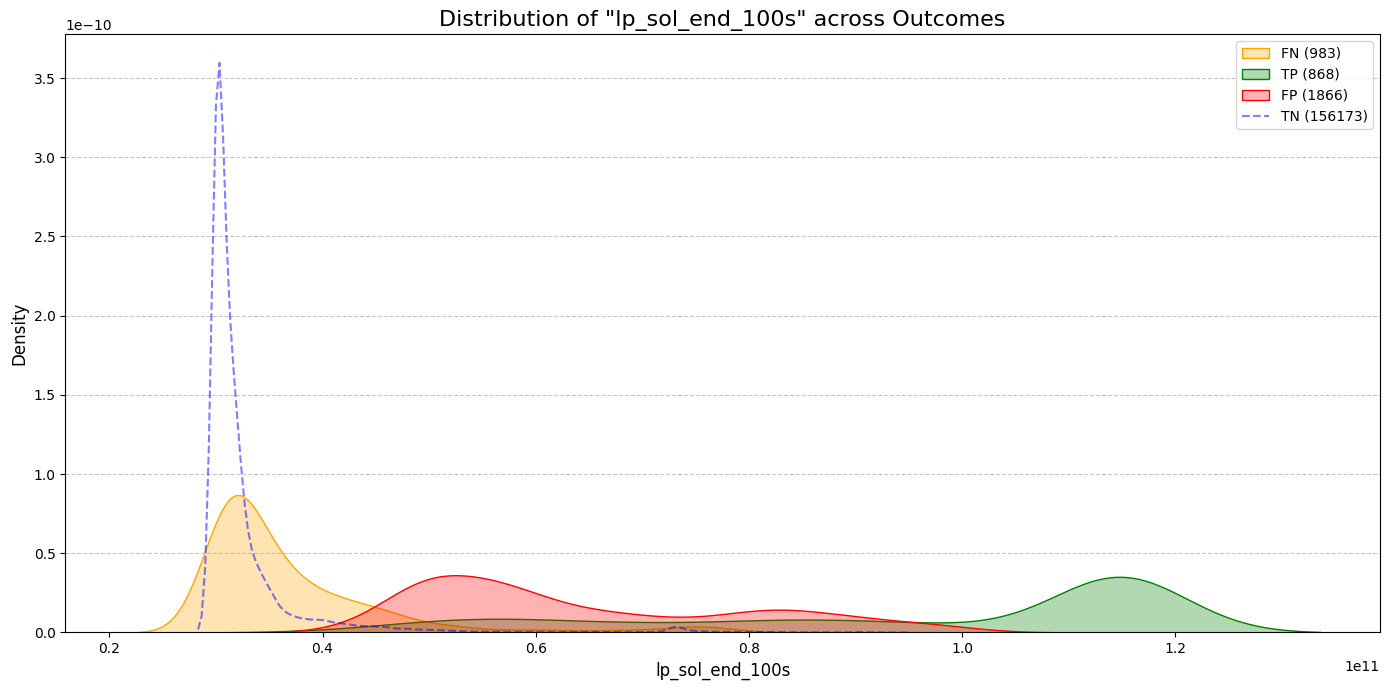


Plotting for feature: last_slot_offset_100s


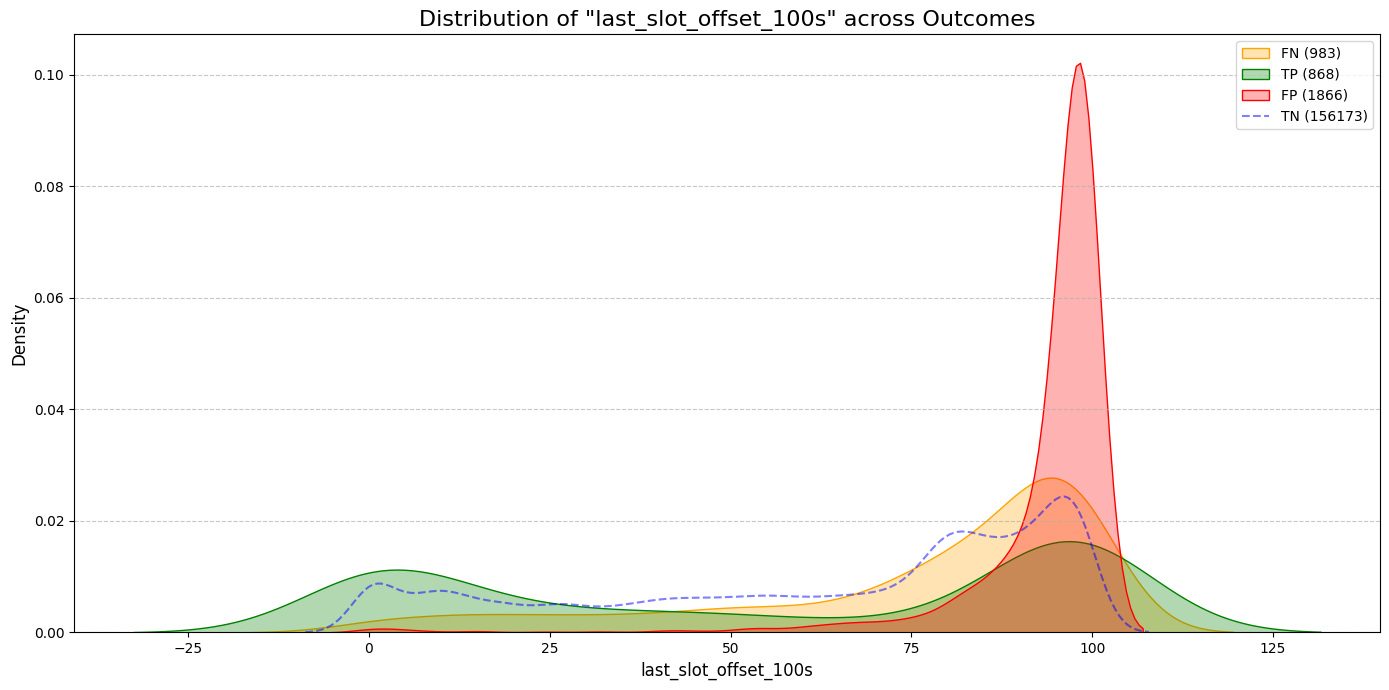


Plotting for feature: lp_token_end_100s


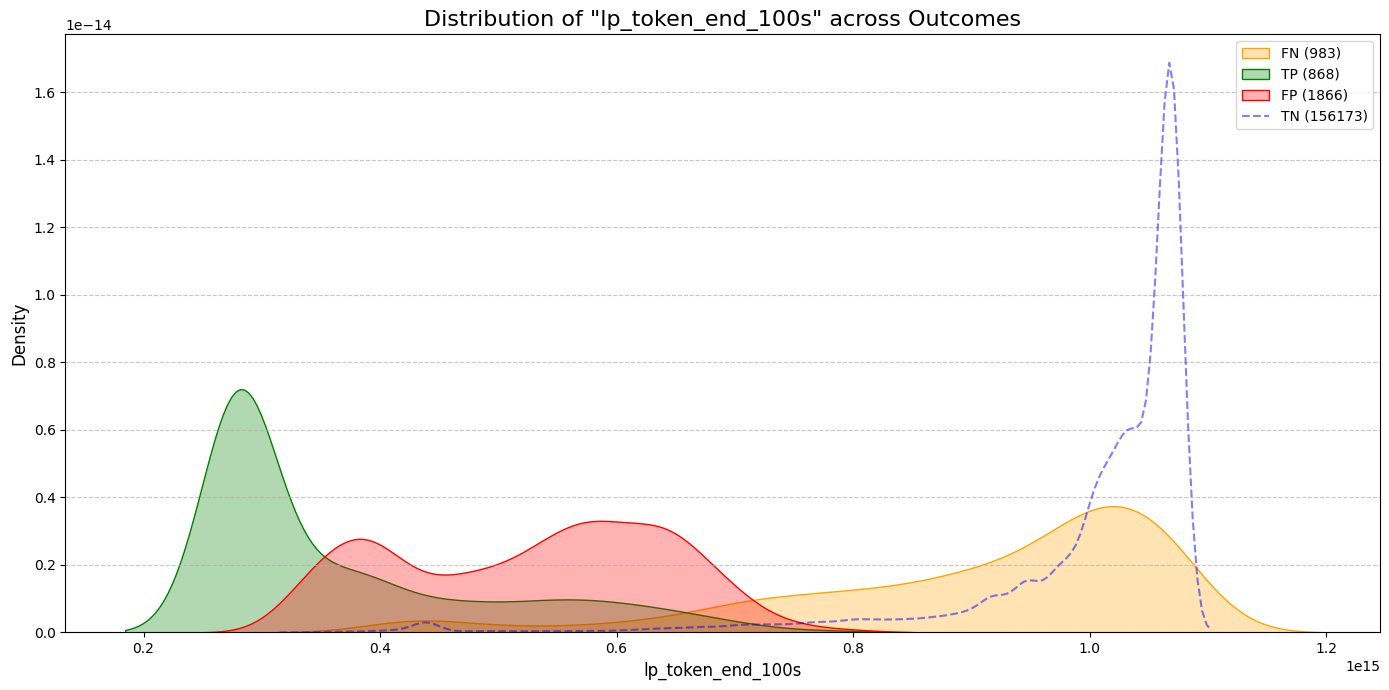


--- 7. Overall Summary and Potential Next Steps ---

Key Observations (Review the detailed output above):
1.  **False Negatives (FNs):** Identify features where FNs consistently show lower/higher values or different distributions compared to TPs. Are these the 'low activity' cases noted before? Are there *any* features where FNs look similar to TPs?
2.  **False Positives (FPs):** Identify features where FPs look significantly different from TNs (suggesting why they were flagged). Crucially, identify features where FPs look *similar* to TPs (suggesting sources of confusion for the model). Temporal features like 'last_slot_offset_100s' or 'time_span_seconds_100s' might be important here based on the previous analysis.
3.  **Feature Importance Alignment:** Do the most important features show clear separation between TP/TN or significant differences involving error types? Are the least important features showing little difference across groups?
4.  **Probability Scores:** Revisit the FN p

In [ ]:
# --- 2. Identify Error Types and True Outcomes ---
print("\n--- 2. Identifying Error Types and True Outcomes ---")

# Define filters
fn_filter = (analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 0)
tp_filter = (analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 1)
fp_filter = (analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 1)
tn_filter = (analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 0)

# Create subsets
false_negatives = analysis_df[fn_filter]
true_positives = analysis_df[tp_filter]
false_positives = analysis_df[fp_filter]
true_negatives = analysis_df[tn_filter]

# Store counts
counts = {
    "FN (Missed Positives)": len(false_negatives),
    "TP (Correct Positives)": len(true_positives),
    "FP (False Alarms)": len(false_positives),
    "TN (Correct Negatives)": len(true_negatives)
}

print("Outcome Counts:")
for name, count in counts.items():
    print(f"- {name}: {count}")

# Basic Sanity Check
total_analyzed = sum(counts.values())
if total_analyzed != len(analysis_df):
    print(f"WARNING: Sum of outcomes ({total_analyzed}) does not match total validation samples ({len(analysis_df)})!")
else:
    print(f"Total Validation Samples Analyzed: {total_analyzed}")


# --- 3. Analyze Predicted Probabilities for Error Groups ---
print("\n--- 3. Analyzing Predicted Probabilities for Error Groups ---")

print("\nPredicted Probabilities for False Negatives (Should be < 0.5):")
if not false_negatives.empty:
    print(false_negatives['predicted_proba'].describe())
else:
    print("No False Negatives to analyze.")

print("\nPredicted Probabilities for False Positives (Should be >= 0.5):")
if not false_positives.empty:
    print(false_positives['predicted_proba'].describe())
else:
    print("No False Positives to analyze.")

# --- 4. Get Feature Importances (Optional but Recommended) ---
print("\n--- 4. Feature Importances from Model ---")
try:
    # For CatBoost
    feature_importances = pd.Series(final_model.get_feature_importance(), index=final_model.feature_names_)
    # For Scikit-learn models (like RandomForest, GradientBoostingClassifier)
    # feature_importances = pd.Series(final_model.feature_importances_, index=final_model.feature_names_in_)

    # Sort importances
    feature_importances = feature_importances.sort_values(ascending=False)

    print("Top 20 Most Important Features:")
    print(feature_importances.head(20))
    print("\nBottom 10 Least Important Features:")
    print(feature_importances.tail(10))
    most_important_features = feature_importances.head(15).index.tolist() # Keep track for focused analysis later
    least_important_features = feature_importances.tail(10).index.tolist()
except AttributeError:
    print("Could not automatically retrieve feature importances from the model.")
    print("You may need to adapt the code based on your specific model type.")
    most_important_features = []
    least_important_features = list(X_val.columns[:5]) # Fallback: analyze first 5 features if importance fails
except Exception as e:
    print(f"An error occurred retrieving feature importances: {e}")
    most_important_features = []
    least_important_features = list(X_val.columns[:5]) # Fallback

# --- 5. Detailed Feature-by-Feature Analysis ---
print("\n--- 5. Detailed Feature-by-Feature Analysis ---")

# Define percentiles to calculate for distribution analysis
percentiles = [0.10, 0.25, 0.50, 0.75, 0.90]
feature_list = X_val.columns # Analyze all original features

# Limit analysis if too many features for readability (optional)
# MAX_FEATURES_TO_ANALYZE = 30
# if len(feature_list) > MAX_FEATURES_TO_ANALYZE:
#     print(f"\nINFO: Analyzing only the top {len(most_important_features)} most important features due to large number of features.")
#     feature_list = most_important_features


analysis_summary = {} # To store findings per feature

for feature in feature_list:
    print(f"\n---------------- Feature: {feature} ----------------")
    feature_results = {}

    # Calculate stats for each group
    stats = {}
    for name, df in [('FN', false_negatives), ('TP', true_positives), ('FP', false_positives), ('TN', true_negatives)]:
        if not df.empty:
            desc = df[feature].describe(percentiles=percentiles)
            # Ensure all percentiles are present even if describe doesn't output them by default for some reason
            percentile_values = {f"{int(p*100)}%": desc.get(f"{int(p*100)}%", np.nan) for p in percentiles}
            stats[name] = {
                'count': int(desc.get('count', 0)),
                'mean': desc.get('mean', np.nan),
                'std': desc.get('std', np.nan),
                'min': desc.get('min', np.nan),
                **percentile_values, # Add P10, P25, P50, P75, P90
                'max': desc.get('max', np.nan)
            }
        else:
            stats[name] = {k: np.nan for k in ['count', 'mean', 'std', 'min', '10%', '25%', '50%', '75%', '90%', 'max']}

    # Present stats in a comparative way
    print("\nComparative Statistics:")
    stats_df = pd.DataFrame(stats).T # Transpose for better readability
    # Define order for better comparison
    col_order = ['count', 'mean', 'std', 'min', '10%', '25%', '50%', '75%', '90%', 'max']
    print(stats_df[col_order].to_string(float_format='{:,.2f}'.format)) # Format numbers nicely

    feature_results['stats_df'] = stats_df

    # --- Automated Insights (Textual Summary Generation) ---
    insights = []
    # Compare FN vs TP (Why are positives missed?)
    if stats['FN']['count'] > 0 and stats['TP']['count'] > 0:
        fn_median = stats['FN']['50%']
        tp_median = stats['TP']['50%']
        fn_mean = stats['FN']['mean']
        tp_mean = stats['TP']['mean']
        # Check for significant median/mean differences
        if not (np.isnan(fn_median) or np.isnan(tp_median)):
            if fn_median < tp_median * 0.8: # FN median significantly lower (adjust multiplier as needed)
                insights.append(f"FN vs TP: FNs tend to have lower values (median {fn_median:,.2f}) than TPs (median {tp_median:,.2f}).")
            elif fn_median > tp_median * 1.2: # FN median significantly higher
                insights.append(f"FN vs TP: FNs tend to have higher values (median {fn_median:,.2f}) than TPs (median {tp_median:,.2f}).")

        # Check distribution overlap using P25/P75
        fn_p75 = stats['FN']['75%']
        tp_p25 = stats['TP']['25%']
        if not (np.isnan(fn_p75) or np.isnan(tp_p25)):
             if fn_p75 < tp_p25:
                 insights.append(f"FN vs TP: Distributions show limited overlap (FN P75 < TP P25). Feature might strongly separate these groups if FN levels were higher.")
        # Check upper tails
        fn_p90 = stats['FN']['90%']
        tp_p50 = stats['TP']['50%']
        if not (np.isnan(fn_p90) or np.isnan(tp_p50)):
            if fn_p90 < tp_p50:
                 insights.append(f"FN vs TP: Even the highest 10% of FNs are below the median TP value. FNs lack the high values seen in TPs.")


    # Compare FP vs TN (Why are negatives misclassified?)
    if stats['FP']['count'] > 0 and stats['TN']['count'] > 0:
        fp_median = stats['FP']['50%']
        tn_median = stats['TN']['50%']
        # Check for significant median/mean differences
        if not (np.isnan(fp_median) or np.isnan(tn_median)):
            if fp_median < tn_median * 0.8: # FP median significantly lower
                insights.append(f"FP vs TN: FPs tend to have lower values (median {fp_median:,.2f}) than TNs (median {tn_median:,.2f}).")
            elif fp_median > tn_median * 1.2: # FP median significantly higher
                insights.append(f"FP vs TN: FPs tend to have higher values (median {fp_median:,.2f}) than TNs (median {tn_median:,.2f}). Model might be misinterpreting these higher values as positive signal.")

        # Check distribution overlap using P25/P75
        fp_p25 = stats['FP']['25%']
        tn_p75 = stats['TN']['75%']
        if not (np.isnan(fp_p25) or np.isnan(tn_p75)):
             if fp_p25 > tn_p75:
                 insights.append(f"FP vs TN: Distributions show limited overlap (FP P25 > TN P75). Feature might strongly separate these groups, FPs look distinct from most TNs.")

    # Compare FP vs TP (Do FPs look like TPs?)
    if stats['FP']['count'] > 0 and stats['TP']['count'] > 0:
        fp_median = stats['FP']['50%']
        tp_median = stats['TP']['50%']
        if not (np.isnan(fp_median) or np.isnan(tp_median)):
             # Use a tighter threshold for similarity
             if abs(fp_median - tp_median) < (abs(tp_median) * 0.15 + 1e-6): # Medians within ~15%
                  insights.append(f"FP vs TP: Medians are similar (FP: {fp_median:,.2f}, TP: {tp_median:,.2f}). FPs might mimic TPs on this feature's central tendency.")

        fp_p25 = stats['FP']['25%']
        tp_p25 = stats['TP']['25%']
        fp_p75 = stats['FP']['75%']
        tp_p75 = stats['TP']['75%']
        if not any(np.isnan([fp_p25, tp_p25, fp_p75, tp_p75])):
             # Check if interquartile ranges overlap significantly
             iqr_overlap = max(0, min(fp_p75, tp_p75) - max(fp_p25, tp_p25))
             fp_iqr = fp_p75 - fp_p25
             tp_iqr = tp_p75 - tp_p25
             if iqr_overlap > 0 and (fp_iqr > 1e-6 and tp_iqr > 1e-6): # Avoid division by zero
                 if (iqr_overlap / fp_iqr > 0.5) and (iqr_overlap / tp_iqr > 0.5): # Significant overlap if >50% of both IQRs overlap
                     insights.append(f"FP vs TP: Significant overlap in interquartile ranges (P25-P75). FPs and TPs share common values in the middle 50% of their distributions.")

    # Print generated insights
    print("\nAutomated Insights:")
    if insights:
        for insight in insights:
            print(f"- {insight}")
    else:
        print("- No obvious strong distinguishing patterns detected based on median/quartile comparisons.")

    feature_results['insights'] = insights
    analysis_summary[feature] = feature_results


# --- 6. Visualization Helper Function ---
print("\n--- 6. Visualization Helper ---")

def plot_feature_distributions(analysis_df, feature_name):
    """Generates density plots comparing FN, TP, FP, TN for a given feature."""
    plt.figure(figsize=(14, 7))

    # Define filters again locally or pass df subsets
    fn = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 0)]
    tp = analysis_df[(analysis_df['true_label'] == 1) & (analysis_df['predicted_label'] == 1)]
    fp = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 1)]
    tn = analysis_df[(analysis_df['true_label'] == 0) & (analysis_df['predicted_label'] == 0)]

    # Plot densities
    if not fn.empty:
        sns.kdeplot(fn[feature_name], color="orange", label=f'FN ({len(fn)})', fill=True, alpha=0.3, warn_singular=False)
    if not tp.empty:
        sns.kdeplot(tp[feature_name], color="green", label=f'TP ({len(tp)})', fill=True, alpha=0.3, warn_singular=False)
    if not fp.empty:
        sns.kdeplot(fp[feature_name], color="red", label=f'FP ({len(fp)})', fill=True, alpha=0.3, warn_singular=False)
    if not tn.empty:
        # Plot TNs with less emphasis if the plot gets too crowded, e.g., dashed line
        sns.kdeplot(tn[feature_name], color="blue", label=f'TN ({len(tn)})', linestyle="--", alpha=0.5, warn_singular=False)

    plt.title(f'Distribution of "{feature_name}" across Outcomes', fontsize=16)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # Improve readability for highly skewed data (optional: log scale)
    # Consider adding logic to detect high skew and suggest/apply log scale:
    # skewness = analysis_df[feature_name].skew()
    # if abs(skewness) > 3: # Arbitrary threshold for high skew
    #     plt.xscale('log')
    #     plt.title(f'Distribution of "{feature_name}" (Log Scale) across Outcomes', fontsize=16)

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage of the plotting function for a few key features:
print("\nGenerating example plots for a few features (call this function for any feature of interest):")
features_to_plot_example = []
if most_important_features:
     # Plot top 2 important features
     features_to_plot_example.extend(most_important_features[:2])
     # Plot one feature where FNs/TPs might differ based on earlier stats (e.g., temporal)
     temporal_features = [f for f in ['last_slot_offset_100s', 'time_span_seconds_100s'] if f in X_val.columns]
     if temporal_features:
         features_to_plot_example.append(temporal_features[0])
else:
     # Fallback if importances failed
     features_to_plot_example = list(X_val.columns[:3])

# Ensure unique features and they exist
features_to_plot_example = list(set(features_to_plot_example) & set(X_val.columns))

for feature in features_to_plot_example:
    print(f"\nPlotting for feature: {feature}")
    plot_feature_distributions(analysis_df, feature)


# --- 7. Overall Summary and Potential Next Steps ---
print("\n--- 7. Overall Summary and Potential Next Steps ---")
# This section requires synthesizing the findings from section 5.
# You would manually review the output above or programmatically summarize patterns.

print("\nKey Observations (Review the detailed output above):")
print("1.  **False Negatives (FNs):** Identify features where FNs consistently show lower/higher values or different distributions compared to TPs. Are these the 'low activity' cases noted before? Are there *any* features where FNs look similar to TPs?")
print("2.  **False Positives (FPs):** Identify features where FPs look significantly different from TNs (suggesting why they were flagged). Crucially, identify features where FPs look *similar* to TPs (suggesting sources of confusion for the model). Temporal features like 'last_slot_offset_100s' or 'time_span_seconds_100s' might be important here based on the previous analysis.")
print("3.  **Feature Importance Alignment:** Do the most important features show clear separation between TP/TN or significant differences involving error types? Are the least important features showing little difference across groups?")
print("4.  **Probability Scores:** Revisit the FN probability scores (Section 3). Given the feature distributions, does it make sense why the model assigned low probabilities? Are there identifiable feature ranges for FNs that consistently lead to low scores?")

print("\nPotential Feature Engineering Directions (Based on Analysis):")
print("-   **Interaction Features:** Combine features that show interesting patterns. E.g., if FPs have high `tx_count` but also high `last_slot_offset`, an interaction term might capture this specific pattern (`tx_count * time_span`?).")
print("-   **Ratio Features:** Ratios comparing buy/sell activity, start/end activity, volume/tx_count might capture nuances missed by individual features. (e.g., `buy_tx_count_100s / (sell_tx_count_100s + 1)`)")
print("-   **Temporal Dynamics:** Create features explicitly capturing the 'shape' of activity over the 100 slots (e.g., ratio of activity in first 30 slots vs last 30 slots, time/slot of peak volume).")
print("-   **Handling Skew:** If important features are highly skewed, consider transformations (log, Box-Cox) - CatBoost handles numerical features well, but explicit transformation might occasionally help linearity assumptions if other models were used, or sometimes aids interpretation.")
print("-   **Addressing Low-Activity FNs:** This remains challenging. Look for *any* feature (even low importance ones) where FNs show a distinct pattern, perhaps related to specific LP changes (`lp_sol_change_pct_100s`?) or consistency measures (e.g., low standard deviation of tx amounts despite low total volume?).")

print("\nRecommendation:")
print("1.  **Review the detailed feature-by-feature output** above carefully.")
print("2.  **Use the `plot_feature_distributions` function** for features that seem particularly interesting or confusing.")
print("3.  **Prioritize feature engineering** based on the insights gained, focusing on separating FPs from TPs/TNs and finding signals for FNs.")
print("4.  **Retrain the model** with new/modified features and repeat the evaluation and analysis cycle.")
print("5.  **Consider threshold tuning** (using PR curves or F1-optimization on validation probabilities) as a final step *after* feature engineering, especially if FPs have probabilities clustered just above 0.5.")

print("\nAnalysis Script Execution Complete.")

In [ ]:
# --- 3. Train the Model (CATBOOST) ---
print("\nTraining CatBoost model...")

# Initialize CatBoost Classifier
# CatBoost handles NaNs by default. No need for explicit imputation.
# We can also specify categorical features if any were included (none in this set).
model = catboost.CatBoostClassifier(
    iterations=1000, # You can increase this for better performance
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss', # Suitable for binary classification
    eval_metric='Logloss',
    random_seed=42,
    verbose=100, # Print progress every 100 iterations
    early_stopping_rounds=50, # Stop if metric doesn't improve for 50 iterations
    task_type='GPU',
)

# Train the model
# CatBoost automatically handles NaNs in numerical features.
model.fit(X_train, y_train,
          # No categorical_features specified as all engineered features are numerical
          # Can add validation_set=(X_val, y_val) for early stopping if you split train data
         )

print("Model training complete.")


Training CatBoost model...
0:	learn: 0.5766263	total: 25.8ms	remaining: 25.8s
100:	learn: 0.0392852	total: 1.33s	remaining: 11.8s
200:	learn: 0.0386582	total: 2.52s	remaining: 10s
300:	learn: 0.0381764	total: 3.71s	remaining: 8.63s
400:	learn: 0.0377601	total: 6.83s	remaining: 10.2s
500:	learn: 0.0373844	total: 8.45s	remaining: 8.42s
600:	learn: 0.0370401	total: 9.65s	remaining: 6.41s
700:	learn: 0.0366914	total: 10.9s	remaining: 4.63s
800:	learn: 0.0363850	total: 12.1s	remaining: 3s
900:	learn: 0.0361059	total: 13.3s	remaining: 1.46s
999:	learn: 0.0358166	total: 14.5s	remaining: 0us
Model training complete.


# --- 4. Prepare Test Data ---
1. Merge test mints with the engineered features
2. Use a left merge from test_df to keep all test mints.
3. Mints in test_df that are NOT in features_df will have NaN for features.

In [ ]:
test_with_features = pd.merge(
    test_df[['mint']], # Keep only mint from test
    features_df,
    on='mint',
    how='left'
)

print(f"\nTest data shape after merging features: {test_with_features.shape}")
print("Test data head:")
print(test_with_features.head())


# Ensure test features have the same columns as training features and in the same order
# Important: If a column exists in X_train but not in test_with_features (unlikely with a left merge
# from test_df), it would need to be added with NaNs. Conversely, if a column exists in test_with_features
# but not in X_train (also unlikely), it should be dropped.
X_test = test_with_features[feature_columns] # Select the same feature columns as used for training

# Handle NaNs in test features. CatBoost will handle them during prediction as it did during training.
# No explicit imputation needed for CatBoost.

print(f"\nTest features shape (X_test): {X_test.shape}")
print("X_test info (showing NaNs):")
X_test.info(verbose=True, show_counts=True)


Test data shape after merging features: (478832, 70)
Test data head:
                                           mint  tx_count_100s  \
0  9Wt3N7etKMX9cioTdEJ5S4b8A9nK3M66n9RFVgBGpump            5.0   
1  9q5y2X2P8ZEKTjyXBVcS5q2EZM7HbNV8DURY2qnvqi2f           13.0   
2  HL2di8dcQ7eYDmkcFoZ4zJyHX5SbRZXAJxTegL3JPfx2           23.0   
3  7iAFj9Pc5QH9jbGmHwYe8T6yzNVbjhL13PNJXVTspump            4.0   
4  F7U1Rdgz2KFpneKpAnYytWF2jggnsrLScfi2A668pump            9.0   

   buy_tx_count_100s  sell_tx_count_100s  total_sol_vol_100s  \
0                4.0                 1.0        1.636599e+09   
1                8.0                 5.0        5.022434e+09   
2               15.0                 8.0        1.581081e+10   
3                3.0                 1.0        3.869155e+09   
4                6.0                 3.0        1.686279e+09   

   buy_sol_vol_100s  sell_sol_vol_100s  total_token_vol_100s  \
0      1.574777e+09       6.182135e+07          5.551538e+13   
1      2.543365e+09 

# --- 5. Make Predictions ---

In [ ]:
print("\nMaking predictions on test data...")
# Predict probabilities for the positive class (graduation)
p = final_model.predict_proba(X_test)[:, 1]

print("Predictions complete.")
print(f"Generated {len(p)} predictions.")


Making predictions on test data...
Predictions complete.
Generated 478832 predictions.


# --- 6. Create Submission File ---

In [ ]:
submission_df = test_with_features[['mint']].copy() # Start with test mints
submission_df['has_graduated'] = p

print("Submission DataFrame head:")
print(submission_df.head())

# Sanity check
assert submission_df.shape[0] == test_df.shape[0], "Submission row count mismatch!"
print(f"Submission shape matches test shape: {submission_df.shape[0]}")

# Save the submission file
submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"\nSubmission file saved to {submission_path}")

Submission DataFrame head:
                                           mint  has_graduated
0  9Wt3N7etKMX9cioTdEJ5S4b8A9nK3M66n9RFVgBGpump       0.059091
1  9q5y2X2P8ZEKTjyXBVcS5q2EZM7HbNV8DURY2qnvqi2f       0.033924
2  HL2di8dcQ7eYDmkcFoZ4zJyHX5SbRZXAJxTegL3JPfx2       0.028086
3  7iAFj9Pc5QH9jbGmHwYe8T6yzNVbjhL13PNJXVTspump       0.102447
4  F7U1Rdgz2KFpneKpAnYytWF2jggnsrLScfi2A668pump       0.050901
Submission shape matches test shape: 478832

Submission file saved to submission.csv
